# Data representation

## Transforming sequential (time series) data to supervised learning task

### Task: Time Series (Sequence) Forecasting with LSTM-Recurrent Neural Networks (RNN)

In this tutorial, we will show an example for preprocessing time series data (structured data) for our LSTM model 

* How to transform a raw dataset into something we can use for time series forecasting.
* How to prepare data and fit an LSTM for a multivariate time series forecasting problem.
* How to make a forecast and rescale the result back into the original units.

### 1. Basic data preparation

### Data set: Air Pollution Forecasting

In this tutorial, we are going to use pollution dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

Original source for downloading the data is in UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

The data includes attributes as follows:

```
1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain
```

#### Quick view of raw data (before preprocessing)

```
No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
1,2010,1,1,0,NA,-21,-11,1021,NW,1.79,0,0
2,2010,1,1,1,NA,-21,-12,1020,NW,4.92,0,0
3,2010,1,1,2,NA,-21,-11,1019,NW,6.71,0,0
4,2010,1,1,3,NA,-21,-14,1019,NW,9.84,0,0
5,2010,1,1,4,NA,-20,-12,1018,NW,12.97,0,0
	
```

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

In [1]:
from pandas import read_csv
from datetime import datetime
import os
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat

In [2]:
DATA_PATH = '../data'

#### Function to parse time attributes into one cell time series format

The first step is to consolidate the date-time information into a single date-time so that we can use it as an index in Pandas.

In [3]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

Load raw dataset and parses the date-time information as index. The “No” column is dropped.

In [4]:
dataset = read_csv(os.path.join(DATA_PATH,'air_pollution.csv'),  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [5]:
dataset.drop('No', axis=1, inplace=True)

Quick view of data set after first stage of preprocessing

In [6]:
dataset[:5]

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [7]:
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

After being assigned new column (attribute) name:

In [8]:
dataset[:5]

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Notice that attribute `pollution` has NA values. We replace the NA values with `0`.

In [9]:
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

Notice that we also don not have meaningful data in the first 24 hours: attribute `pollution` (as our prediction attribute) has only NA values for the first 24 hours. Therefore, we need to remove these first 24 rows of data. 

In [10]:
# drop the first 24 hours
dataset = dataset[24:]

In [11]:
# summarize first 5 rows
print(dataset.head(5))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [12]:
# save to file
dataset.to_csv(os.path.join(DATA_PATH,'prep_air_pollution.csv'))

Now that we have the data in an easy-to-use form, we can create a quick plot of each series and see what we have.

The code below loads the new “pollution.csv” file and plots each series as a separate subplot, except wind speed dir, which is categorical.

In [13]:
from matplotlib import pyplot
# load dataset
dataset = read_csv(os.path.join(DATA_PATH,'prep_air_pollution.csv'), header=0, index_col=0)
values = dataset.values

In [14]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

Running the example creates a plot with 7 subplots showing the 5 years of data for each variable.

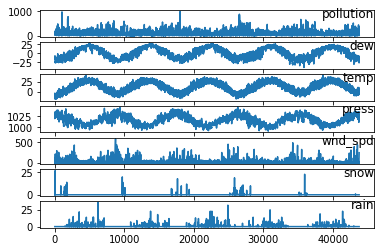

In [15]:
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### 2. LSTM data preparation

The first step is to prepare the pollution dataset for the LSTM-RNN model. This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

Some alternate formulations you could explore include:

* Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
* Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.

Before going to further preprocess `air pollution` data set, the following code shows us the example of reframing original sequential data set into supervised learning task.

#### 2.a. Transforming sequential data to supervised learning task 

#### Example of shifting time series data

In [16]:
df = DataFrame()
df['t'] = [x for x in range(10)]
print(df)

   t
0  0
1  1
2  2
3  3
4  4
5  5
6  6
7  7
8  8
9  9


In [17]:
df['t-1'] = df['t'].shift(1)
print(df)

   t  t-1
0  0  NaN
1  1  0.0
2  2  1.0
3  3  2.0
4  4  3.0
5  5  4.0
6  6  5.0
7  7  6.0
8  8  7.0
9  9  8.0


In [18]:
df['t+1'] = df['t'].shift(-1)
print(df)

   t  t-1  t+1
0  0  NaN  1.0
1  1  0.0  2.0
2  2  1.0  3.0
3  3  2.0  4.0
4  4  3.0  5.0
5  5  4.0  6.0
6  6  5.0  7.0
7  7  6.0  8.0
8  8  7.0  9.0
9  9  8.0  NaN


Technically, in time series forecasting terminology the current time (t) and future times (t+1, t+n) are forecast times and past observations (t-1, t-n) are used to make forecasts.

#### The series_to_supervised() Function

The function takes four arguments:

data: Sequence of observations as a list or 2D NumPy array. Required.
n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.
n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.
The function returns a single value:

return: Pandas DataFrame of series framed for supervised learning.

In [19]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#### 2.b. Type of sequence forecasting

#### + One step sequence forecasting

In [20]:
val = [x for x in range(10)]
dat = series_to_supervised(val)

In [21]:
print(dat)

   var1(t-1)  var1(t)
1        0.0        1
2        1.0        2
3        2.0        3
4        3.0        4
5        4.0        5
6        5.0        6
7        6.0        7
8        7.0        8
9        8.0        9


In [22]:
val = [x for x in range(10)]
dat = series_to_supervised(val,3)

In [23]:
print(dat)

   var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
3        0.0        1.0        2.0        3
4        1.0        2.0        3.0        4
5        2.0        3.0        4.0        5
6        3.0        4.0        5.0        6
7        4.0        5.0        6.0        7
8        5.0        6.0        7.0        8
9        6.0        7.0        8.0        9


#### + Multi steps sequence forecasting

In [24]:
val = [x for x in range(10)]
dat = series_to_supervised(val,2,2)

In [25]:
print(dat)

   var1(t-2)  var1(t-1)  var1(t)  var1(t+1)
2        0.0        1.0        2        3.0
3        1.0        2.0        3        4.0
4        2.0        3.0        4        5.0
5        3.0        4.0        5        6.0
6        4.0        5.0        6        7.0
7        5.0        6.0        7        8.0
8        6.0        7.0        8        9.0


#### + Multivariate sequence forecasting

In multivariate time series problems, instead of having one set of observations for a time series, we have multiple attributes(e.g. temperature and pressure). All variates in the time series can be shifted forward or backward to create multivariate input and output sequences. 

In [26]:
raw = DataFrame()
raw['ob1'] = [x for x in range(10)]
raw['ob2'] = [x for x in range(50, 60)]

In [27]:
print(raw)

   ob1  ob2
0    0   50
1    1   51
2    2   52
3    3   53
4    4   54
5    5   55
6    6   56
7    7   57
8    8   58
9    9   59


In [28]:
val = raw.values
print(val)

[[ 0 50]
 [ 1 51]
 [ 2 52]
 [ 3 53]
 [ 4 54]
 [ 5 55]
 [ 6 56]
 [ 7 57]
 [ 8 58]
 [ 9 59]]


In [29]:
dat = series_to_supervised(val)
print(dat)

   var1(t-1)  var2(t-1)  var1(t)  var2(t)
1        0.0       50.0        1       51
2        1.0       51.0        2       52
3        2.0       52.0        3       53
4        3.0       53.0        4       54
5        4.0       54.0        5       55
6        5.0       55.0        6       56
7        6.0       56.0        7       57
8        7.0       57.0        8       58
9        8.0       58.0        9       59


#### 2.c. Preprocessing sequence in pollution data set

First, the “pollution.csv” dataset is loaded. 

In [30]:
# load dataset
dataset = read_csv(os.path.join(DATA_PATH,'prep_air_pollution.csv'), header=0, index_col=0)
values = dataset.values

The wind speed feature is label encoded (integer encoded). 

In [31]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

In [32]:
# ensure all data is float
values = values.astype('float32')

Next, all features are normalized, then the dataset is transformed into a supervised learning problem. 

In [33]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [34]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

Running the example prints the first 5 rows of the transformed dataset. We can see the 8 input variables (input series) and the 1 output variable (pollution level at the current hour).

In [35]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


This data preparation is simple and there is more we could explore. Some ideas you could look at include:

* One-hot encoding wind speed.
* Making all series stationary with differencing and seasonal adjustment.
* Providing more than 1 hour of input time steps.

This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

### 3. Define model and fit on preprocessed data

#### Splitting data into training and testing sets

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [36]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [37]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [38]:
train_X.shape

(8760, 8)

In [39]:
test_X.shape

(35039, 8)

Running this example prints the shape of the train and test input and output sets with about 9K hours of data for training and about 35K hours for testing.

In [40]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

In [41]:
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [42]:
train_X.shape

(8760, 1, 8)

In [43]:
train_y.shape

(8760,)

In [44]:
test_X.shape

(35039, 1, 8)

In [45]:
test_y.shape

(35039,)

#### Defining model

We will define the LSTM model with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

In [46]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Using TensorFlow backend.


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this). Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [48]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0547 - val_loss: 0.0536
Epoch 2/50
 - 2s - loss: 0.0356 - val_loss: 0.0564
Epoch 3/50
 - 2s - loss: 0.0228 - val_loss: 0.0445
Epoch 4/50
 - 2s - loss: 0.0184 - val_loss: 0.0396
Epoch 5/50
 - 1s - loss: 0.0164 - val_loss: 0.0276
Epoch 6/50
 - 1s - loss: 0.0154 - val_loss: 0.0194
Epoch 7/50
 - 1s - loss: 0.0148 - val_loss: 0.0167
Epoch 8/50
 - 1s - loss: 0.0147 - val_loss: 0.0161
Epoch 9/50
 - 2s - loss: 0.0149 - val_loss: 0.0154
Epoch 10/50
 - 1s - loss: 0.0147 - val_loss: 0.0150
Epoch 11/50
 - 2s - loss: 0.0148 - val_loss: 0.0149
Epoch 12/50
 - 2s - loss: 0.0147 - val_loss: 0.0144
Epoch 13/50
 - 1s - loss: 0.0148 - val_loss: 0.0145
Epoch 14/50
 - 1s - loss: 0.0146 - val_loss: 0.0140
Epoch 15/50
 - 1s - loss: 0.0146 - val_loss: 0.0140
Epoch 16/50
 - 1s - loss: 0.0145 - val_loss: 0.0139
Epoch 17/50
 - 2s - loss: 0.0145 - val_loss: 0.0138
Epoch 18/50
 - 2s - loss: 0.0144 - val_loss: 0.0137
Epoch 19/50
 - 2s - loss

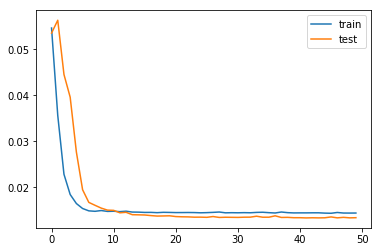

In [49]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### 3. Evaluate Model

After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [50]:
train_X.shape

(8760, 1, 8)

In [51]:
test_X.shape

(35039, 1, 8)

In [52]:
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [53]:
from math import sqrt
from numpy import concatenate

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [60]:
yhat

array([[ 0.03442025],
       [ 0.03059679],
       [ 0.01994472],
       ..., 
       [ 0.00782922],
       [ 0.0078111 ],
       [ 0.00606755]], dtype=float32)

0.07063755

In [64]:
test_X

array([[ 0.0362173 ,  0.33823532,  0.1967213 , ...,  0.12757413,
         0.        ,  0.        ],
       [ 0.03118712,  0.33823532,  0.1967213 , ...,  0.006101  ,
         0.        ,  0.        ],
       [ 0.02012072,  0.33823532,  0.1967213 , ...,  0.0145091 ,
         0.        ,  0.        ],
       ..., 
       [ 0.01006036,  0.2647059 ,  0.26229507, ...,  0.40558836,
         0.        ,  0.        ],
       [ 0.01006036,  0.2647059 ,  0.26229507, ...,  0.41399646,
         0.        ,  0.        ],
       [ 0.00804829,  0.2647059 ,  0.24590163, ...,  0.42086649,
         0.        ,  0.        ]], dtype=float32)

In [65]:
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat

array([[ 0.03442025,  0.33823532,  0.1967213 , ...,  0.12757413,
         0.        ,  0.        ],
       [ 0.03059679,  0.33823532,  0.1967213 , ...,  0.006101  ,
         0.        ,  0.        ],
       [ 0.01994472,  0.33823532,  0.1967213 , ...,  0.0145091 ,
         0.        ,  0.        ],
       ..., 
       [ 0.00782922,  0.2647059 ,  0.26229507, ...,  0.40558836,
         0.        ,  0.        ],
       [ 0.0078111 ,  0.2647059 ,  0.26229507, ...,  0.41399646,
         0.        ,  0.        ],
       [ 0.00606755,  0.2647059 ,  0.24590163, ...,  0.42086649,
         0.        ,  0.        ]], dtype=float32)

In [67]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat

array([[  34.21372604,  -17.        ,   -7.        , ...,   75.09999847,
           0.        ,    0.        ],
       [  30.41321373,  -17.        ,   -7.        , ...,    4.01999998,
           0.        ,    0.        ],
       [  19.82505035,  -17.        ,   -7.        , ...,    8.93999958,
           0.        ,    0.        ],
       ..., 
       [   7.78224945,  -22.        ,   -3.00000024, ...,  237.77999878,
           0.        ,    0.        ],
       [   7.76423836,  -22.        ,   -3.00000024, ...,  242.69999695,
           0.        ,    0.        ],
       [   6.03114748,  -22.        ,   -4.        , ...,  246.72000122,
           0.        ,    0.        ]], dtype=float32)

In [54]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [55]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.447
